# Extrapolation of low-energy CR spectra for all elements

Based on "GCR vs SS elemental abundances" from [CRDB gallery](https://github.com/crdb-project/tutorial/blob/main/gallery.ipynb)

In [9]:
import crdb
from crdb.experimental import convert_energy
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.rcsetup import cycler
from matplotlib.ticker import MultipleLocator, LogLocator
import numpy as np
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [10]:
cc = (
    # standard markers for our plots
    cycler(marker=["o", "s", "D", "v", "^", "<", ">"])
    * cycler(color=mcolors.TABLEAU_COLORS)
)

plt.rcParams["lines.markersize"] = 5
plt.rcParams["axes.prop_cycle"] = cc
plt.rcParams["figure.constrained_layout.use"] = True

N.B.: to get help on functions from `crdb` library... see [tutorial.ipynb](https://github.com/crdb-project/tutorial/blob/main/tutorial.ipynb)


## GCR vs SS elemental abundances <a id='GCR_vs_SS'></a> ([go to top](#top))

We plot the famous solar system (SS) versus Galactic cosmic-ray (GCR) composition, illustrating that some CRs are mostly of secondary origin (Li, Be, B, F, subFe...) while others are mostly of primary origin (H, He, O, Si, Fe...).


In [11]:
tab = crdb.all()

In [17]:
elements = []
for q in np.unique(tab.quantity):
    if q in crdb.ELEMENTS:
        elements.append(q)
elements.sort(key=lambda el: crdb.ELEMENTS.get(el, -1))
element_Zs = [crdb.ELEMENTS[el] for el in elements]
print(*[f"{el}: {Z}" for el, Z in zip(elements, element_Zs)], sep="\n")
Z_max = max(element_Zs)
print()
print("Max A:", Z_max)

H: 1
He: 2
Li: 3
Be: 4
B: 5
C: 6
N: 7
O: 8
F: 9
Ne: 10
Na: 11
Mg: 12
Al: 13
Si: 14
P: 15
S: 16
Cl: 17
Ar: 18
K: 19
Ca: 20
Sc: 21
Ti: 22
V: 23
Cr: 24
Mn: 25
Fe: 26
Co: 27
Ni: 28

Max A: 28


In [18]:
mask = False
for q in elements:
    mask |= tab.quantity == q
tab = tab[mask]

# we don't want upper limits
tab = tab[~tab.is_upper_limit]
# statistical errors less than 100 %
tab = tab[np.mean(tab.err_sta, axis=1) / tab.value < 1]
# only measurements at 1 AU
tab = tab[tab.distance == 1]
tab = convert_energy(tab, "R")

xref = 1000  # GV
dlog10x = 1.8
xmin = 10 ** (np.log10(xref) - dlog10x)

# subset of table that we fit above minimum energy
tab_fit = tab[tab.e > xmin]

print(tab_fit.shape)

(35385,)


Perform fits to get flux for each element at the reference point. The following plot is not for the public, it validates the fits.


Text(0, 0.5, '$ (R \\; / \\; \\text{GV})^{2.7} \\times F \\; / \\; (\\mathrm{GeV^{-1} m^{-2} s^{-1} sr^{-1}}) $')

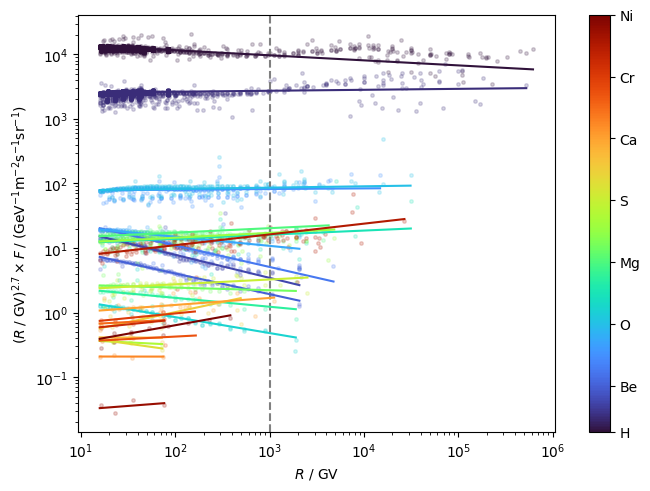

In [19]:
from matplotlib import colors
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots()


def model(x, log_j, gamma):
    return log_j - gamma * np.log(x / xref)


jref = {}
gamma = {}
scale = 2.7
cmap = plt.colormaps["turbo"]

for i, q in enumerate(elements):
    data_all = tab[tab.quantity == q]
    data_fit = tab_fit[tab_fit.quantity == q]
    if len(data_fit) < 2:
        continue

    # prepare arrays for fitting
    x = data_fit.e
    y = data_fit.value
    yerr_stat = np.mean(data_fit.err_sta, axis=1)
    yerr_sys = np.mean(data_fit.err_sys, axis=1)
    yerr_total = np.sqrt(yerr_stat**2 + yerr_sys**2)

    # get starting value for fit
    t3 = data_fit[np.abs(np.log10(data_fit.e) - np.log10(xref)) < dlog10x]
    log_j0 = np.mean(np.log(t3.value))

    # run least-squares fit using MINUIT
    c = LeastSquares(x, np.log(y), yerr_total / y, model)
    m = Minuit(c, log_j0, 2.7)
    m.migrad()
    assert m.valid

    # generate points for the fitted line for validation
    xm = np.geomspace(xmin, np.max(data_all.e))
    ym = np.exp(model(xm, *m.values))

    # compute fitted flux at reference point and uncertainty,
    # apply chi2/ndof scaling of uncertainties to account for
    # systematic offsets between data sets
    jref1 = np.exp(m.values["log_j"])
    jref1_err = m.errors["log_j"] * jref1 * m.fmin.reduced_chi2**0.5

    jref[q] = (jref1, jref1_err)
    gamma[q] = m.values["gamma"]

    # plot everything
    # plt.plot(t.e, t.e ** scale * t.value, ".", zorder=0, color="0.7")
    color = cmap(i / (Z_max - 1))
    l = ax.plot(
        data_fit.e,
        data_fit.e**scale * data_fit.value,
        ".",
        color=colors.to_rgba(color, alpha=0.2),
    )[0]
    ax.plot(xm, xm**scale * ym, "-", zorder=4, color=color)

cbar_primary_Zs = np.linspace(0, Z_max - 1, 8, dtype=int)
fig.colorbar(
    ScalarMappable(norm=colors.Normalize(vmin=0, vmax=Z_max - 1), cmap=cmap),
    ax=ax,
    ticks=cbar_primary_Zs,
    format=lambda param, _: elements[int(param)],
)
ax.axvline(xref, color="0.5", ls="--")
ax.loglog()
ax.set_xlabel("$R$ / GV")
ax.set_ylabel(
    f"$ (R \\; / \\; \\text{{GV}})^{{{scale}}} \\times F \\; / \\; (\\mathrm{{GeV^{{-1}} m^{{-2}} s^{{-1}} sr^{{-1}}}}) $"
)
# fig.tight_layout()

Elemental abundances in cosmic rays at the reference energy compared to abundances in the solar system. The two sets of abundances are scaled so that silicon has a (arbitrary) abundance of $10^6$ in both sets.


Text(0, 0.5, 'Spectral index $ \\gamma $')

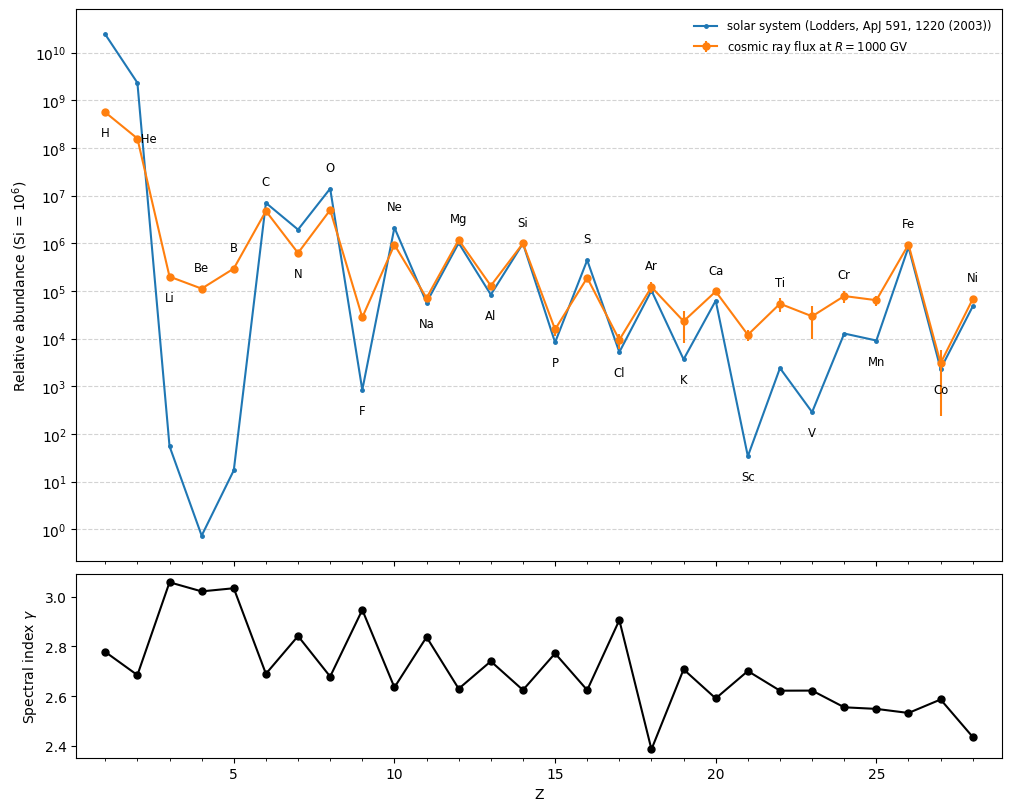

In [20]:
from typing import Sequence

from matplotlib.axes import Axes


fig, axes = plt.subplots(figsize=(10, 8), nrows=2, sharex=True, height_ratios=[3, 1])
axes: Sequence[Axes]
ax, ax_gamma = axes

solar_system_composition = crdb.solar_system_composition()

# normalize cosmic ray abundances so that Si = 1e6
jref0 = jref["Si"][0]
scaling = 1e6 / jref0

data = []
for el, z in crdb.ELEMENTS.items():
    if z > Z_max:
        continue

    if el in solar_system_composition:
        isotopes = solar_system_composition[el]
        ss = sum(x[1] for x in isotopes)
    else:
        ss = np.nan
    j, j_error = jref.get(el, (np.nan, np.nan))
    gamma_ = gamma.get(el, np.nan)
    data.append((z, j * scaling, j_error * scaling, ss, gamma_))
data.sort(key=lambda x: x[0])

x, cr_y, cr_ye, ss_y, gamma_y = np.transpose(data)
elements = [[k for k, v in crdb.ELEMENTS.items() if v == z][0] for z in x]

ax.plot(x, ss_y, "-", marker=".", label="solar system (Lodders, ApJ 591, 1220 (2003))")
ax.errorbar(
    x,
    cr_y,
    cr_ye,
    fmt="o-",
    label="cosmic ray flux at $R = " + f"{xref}$ GV",
)
for eli, xi, yi, y2i in zip(elements, x, cr_y, ss_y):
    if np.isnan(yi) and np.isnan(y2i):
        continue
    if xi == 2:
        ax.text(xi, yi, f" {eli}", ha="left", va="center", fontsize="small")
        continue
    if xi == 3:
        ax.text(xi, yi * 0.5, f"{eli}", ha="center", va="top", fontsize="small")
        continue
    if xi % 2 == 1 and xi not in (5,):
        y = np.nanmin((yi, y2i)) * 0.5
        va = "top"
    else:
        y = np.nanmax((yi, y2i)) * 2
        va = "bottom"
    ax.text(xi, y, f"{eli}", ha="center", va=va, fontsize="small")
ax.legend(frameon=False, fontsize="small")
ax.set_xlim(0.1, np.max(x[~np.isnan(ss_y)]) + 0.9)
ax.set_ylabel("Relative abundance (Si = $10^6$)")
ax.semilogy()
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator())
ax.yaxis.set_major_locator(LogLocator(numticks=100))
ax.grid(visible=True, which="major", axis="y", linestyle="--", color="lightgray")

ax_gamma.plot(x, gamma_y, "ko-")
ax_gamma.set_xlabel("Z")
ax_gamma.set_ylabel("Spectral index $ \\gamma $")

In [23]:
from pprint import pprint


jref_export = {str(el): (float(j_jerr[0]), float(gamma[el])) for el, j_jerr in jref.items()}
pprint(jref_export, sort_dicts=False)

{'H': (7.68049907475221e-05, 2.7780262371892057),
 'He': (2.1694018490738908e-05, 2.685178909671116),
 'Li': (2.7438617719929544e-08, 3.056975412242948),
 'Be': (1.534758103968766e-08, 3.020504875499327),
 'B': (4.048166803672866e-08, 3.033101182101726),
 'C': (6.519811112758188e-07, 2.69033528684777),
 'N': (8.586273486965895e-08, 2.8415453248189646),
 'O': (6.848995794448408e-07, 2.6792700607758615),
 'F': (3.829286411671765e-09, 2.946425241920921),
 'Ne': (1.278287067401656e-07, 2.63590538561923),
 'Na': (9.791216005229198e-09, 2.8375274443126446),
 'Mg': (1.6136065344805168e-07, 2.6305057692716756),
 'Al': (1.7650128638643698e-08, 2.740453808656748),
 'Si': (1.3644773296144594e-07, 2.6252851294491877),
 'P': (2.140995680619696e-09, 2.772129488435299),
 'S': (2.5884695480693985e-08, 2.6250760373070046),
 'Cl': (1.2913579846106572e-09, 2.9053485944514996),
 'Ar': (1.6583806004537737e-08, 2.387656299189939),
 'K': (3.1745896419273668e-09, 2.707988107646582),
 'Ca': (1.338711328284328e